# Peter Moss Acute Myeloid & Lymphoblastic Leukemia AI Research Project
## Acute Lymphoblastic Leukemia Jetson Nano Classifier

![Acute Lymphoblastic Leukemia Jetson Nano Classifier](../assets/images/project-banner.jpg)

# Introduction

The **Acute Lymphoblastic Leukemia Jetson Nano Classifier** is a Convolutional Neural Network (CNN) developed using [Intel® oneAPI AI Analytics Toolkit](https://software.intel.com/content/www/us/en/develop/tools/oneapi.html) and [Intel® Optimization for Tensorflow*](https://software.intel.com/content/www/us/en/develop/articles/getting-started-with-intel-optimization-of-pytorch.html) to accelerate the training process, and [TensorRT](https://developer.nvidia.com/tensorrt) for high performance inference on the [NVIDIA® Jetson Nano™](https://developer.nvidia.com/embedded/jetson-nano-developer-kit).

# DISCLAIMER

_This project should be used for research purposes only. The purpose of the project is to show the potential of Artificial Intelligence for medical support systems such as diagnostic systems._

_Although the model is accurate and shows good results both on paper and in real world testing, it is trained on a small amount of data and needs to be trained on larger datasets to really evaluate it's accuracy._

_Developers that have contributed to this repository have experience in using Artificial Intelligence for detecting certain types of cancer. They are not doctors, medical or cancer experts._

# Software

To use this project you will need to install the following software:

- Conda
- Intel® oneAPI AI Analytics Toolkit
- Jupyter Notebooks
- NBConda 
- Mlxtend
- Pillow
- Opencv
- Scipy
- Scikit Image
- Scikit Learn

# Installation

Before you can begin this tutorial you need to follow the [installation guide](https://github.com/AMLResearchProject/ALL-jetson-Nano/blob/main/docs/installation/ubuntu.md) to install the relevant software and setup your environment.

# Import Modules

In [1]:
import cv2
import os
import pathlib
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from numpy.random import seed
from PIL import Image
from scipy import ndimage
from skimage import transform as tm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline

# Set Global Variables

In [2]:
data_labels = [0, 1]
decay = 1e-6
dim = 100
epochs = 150
lr = 1e-4
rotations = 10
seed_amount = 2
test_split = 0.255
val_steps = 10

valid_files = [
    ".jpg"
]

modelDir = "../model/"
dataDir = modelDir + "data/"
testDataDir = dataDir + "test/"
trainDataDir = dataDir + "train/"

model_path = modelDir + "all_jetson_nano.json"
weights_path = modelDir + "all_jetson_nano.h5"

saved_model_dir = modelDir + "saved"
tfrt_model_dir = modelDir + "tfrt"

testData = [
    "Im006_1.jpg",
    "Im020_1.jpg",
    "Im024_1.jpg",
    "Im026_1.jpg",
    "Im028_1.jpg",
    "Im031_1.jpg",
    "Im035_0.jpg",
    "Im041_0.jpg",
    "Im047_0.jpg",
    "Im053_1.jpg",
    "Im057_1.jpg",
    "Im060_1.jpg",
    "Im063_1.jpg",
    "Im069_0.jpg",
    "Im074_0.jpg",
    "Im088_0.jpg",
    "Im095_0.jpg",
    "Im099_0.jpg",
    "Im101_0.jpg",
    "Im106_0.jpg"
]

seed(seed_amount)
random.seed(seed_amount)

# Data

## ALL-IDB
You need to be granted access to use the Acute Lymphoblastic Leukemia Image Database for Image Processing dataset. You can find the application form and information about getting access to the dataset on [this page](https://homes.di.unimi.it/scotti/all/#download) as well as information on how to contribute back to the project [here](https://homes.di.unimi.it/scotti/all/results.php). If you are not able to obtain a copy of the dataset please feel free to try this tutorial on your own dataset, we would be very happy to find additional AML & ALL datasets.

## ALL_IDB1
In this project, [ALL-IDB1](https://homes.di.unimi.it/scotti/all/#datasets) is used, one of the datsets from the Acute Lymphoblastic Leukemia Image Database for Image Processing dataset. We will use data augmentation to increase the amount of training and testing data we have.

## Data Preprocessing 

In this part of the notebook we will create the methods used for processing the data ready for training.

### Testing Data

First we need to remove the test data that we will use for testing the classifier later from the training data folder. We remove these images before the training so that the classifier does not learn them during training. The following cell provides the function to move the test data to the **model/data/test** folder: 

In [3]:
def remove_testing():
    """ Removes the testing images from the dataset. """

    for img in testData:
        original = trainDataDir+img
        destination = testDataDir+img
        pathlib.Path(original).rename(destination)
        print(original + " moved to " + destination)

### Augmentation

We will create an augmented dataset based on the [Leukemia Blood Cell Image Classification Using Convolutional Neural Network](http://www.ijcte.org/vol10/1198-H0012.pdf "Leukemia Blood Cell Image Classification Using Convolutional Neural Network") by T. T. P. Thanh, Caleb Vununu, Sukhrob Atoev, Suk-Hwan Lee, and Ki-Ryong Kwon.

In [4]:
def resize(path, dim):
    """ Resizes an image to the provided dimensions (dim). """

    return cv2.resize(cv2.imread(path), (dim, dim))

In [5]:
def grayscale(data):
    """ Creates a grayscale copy. """

    gray = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
    return np.dstack([gray, gray, gray]).astype(np.float32)/255.

In [6]:
def equalize_hist(data):
    """ Creates a histogram equalized copy. """

    img_to_yuv = cv2.cvtColor(data, cv2.COLOR_BGR2YUV)
    img_to_yuv[:, :, 0] = cv2.equalizeHist(img_to_yuv[:, :, 0])
    hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    return hist_equalization_result.astype(np.float32)/255.

In [7]:
def reflection(data):
    """ Creates a reflected copy. """

    return cv2.flip(data, 0).astype(np.float32)/255., cv2.flip(data, 1).astype(np.float32)/255.

In [8]:
def gaussian(data):
    """ Creates a gaussian blurred copy. """

    return ndimage.gaussian_filter(data, sigma=5.11).astype(np.float32)/255.

In [9]:
def translate(data):
    """ Creates transformed copy. """

    cols, rows, chs = data.shape

    return cv2.warpAffine(data, np.float32([[1, 0, 84], [0, 1, 56]]), (rows, cols),
                          borderMode=cv2.BORDER_CONSTANT, borderValue=(144, 159, 162)).astype(np.float32)/255.

In [10]:
def rotation(data):
    """ Creates a rotated copy. """

    cols, rows, chs = data.shape

    rand_deg = random.randint(-180, 180)
    matrix = cv2.getRotationMatrix2D((cols/2, rows/2), rand_deg, 0.70)
    rotated = cv2.warpAffine(data, matrix, (rows, cols), borderMode=cv2.BORDER_CONSTANT,
                             borderValue=(144, 159, 162))

    return rotated.astype(np.float32)/255.

In [11]:
def shear(data):
    """ Creates a sheared copy. """

    at = tm.AffineTransform(shear=0.5)
    return tm.warp(data, inverse_map=at)

In [12]:
def preprocess():
    """ Preprocesses the data. """
    
    # Read all data from training dir
    data_dir = pathlib.Path(trainDataDir)
    train_data = list(data_dir.glob('*.jpg'))

    count = 0
    neg_count = 0
    pos_count = 0

    data = []
    labels = []
    temp = []

    # Loop through training data
    for rimage in train_data:
        fpath = str(rimage)
        fname = os.path.basename(rimage)
        label = 0 if "_0" in fname else 1

        # Resize image
        image = resize(fpath, dim)

        if image.shape[2] == 1:
            image = np.dstack(
                [image, image, image])

        temp.append(image.astype(np.float32)/255.)

        data.append(image.astype(np.float32)/255.)
        labels.append(label)

        # Grayscale
        data.append(grayscale(image))
        labels.append(label)

        # Histogram Equalization
        data.append(equalize_hist(image))
        labels.append(label)
        
        # Reflection
        horizontal, vertical = reflection(image)
        data.append(horizontal)
        labels.append(label)

        data.append(vertical)
        labels.append(label)

        # Gaussian Blur
        data.append(gaussian(image))
        labels.append(label)

        # Tranlsation
        data.append(translate(image))
        labels.append(label)

        # Shear
        data.append(shear(image))
        labels.append(label)
        
        # Rotation
        for i in range(0, rotations):
            data.append(rotation(image))
            labels.append(label)
            if "_0" in fname:
                neg_count += 1
            else:
                pos_count += 1
            count +=1

        if "_0" in fname:
            neg_count += 8
        else:
            pos_count += 8
        count +=8

    train_arr = np.asarray(temp)

    print("Augmented data size: " + str(count))
    print("Negative data size: " + str(neg_count))
    print("Positive data size: " + str(pos_count))
    
    return data, labels, train_arr

## Data Preparation

In [13]:
def shuffle_data(data, labels):
    """ Shuffles the data and labels. """

    data, labels = shuffle(
        data, labels, random_state=seed_amount)
    
    return data, labels

In [14]:
def convert_data(data):
    """ Converts the training data to a numpy array. """

    data = np.array(data)
    print("Augmented data shape: " + str(data.shape))
    
    return data

In [15]:
def encode_labels(labels):
    """ One Hot Encodes the labels. """

    encoder = OneHotEncoder(categories='auto')

    labels = np.reshape(labels, (-1, 1))
    labels = encoder.fit_transform(labels).toarray()
    print("Labels shape: " + str(labels.shape))
    
    return labels

## Data Split  

In [16]:
def get_split(data, labels):
    """ Splits the data and labels creating training and validation datasets. """

    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=test_split, random_state=seed_amount)

    print("Training data:     " + str(X_train.shape))
    print("Training labels:   " + str(y_train.shape))
    print("Validation data:   " + str(X_test.shape))
    print("Validation labels: " + str(y_test.shape))
    
    return X_train, X_test, y_train, y_test

## Process & Prepare Data

In [17]:
remove_testing()

../model/data/train/Im006_1.jpg moved to ../model/data/test/Im006_1.jpg
../model/data/train/Im020_1.jpg moved to ../model/data/test/Im020_1.jpg
../model/data/train/Im024_1.jpg moved to ../model/data/test/Im024_1.jpg
../model/data/train/Im026_1.jpg moved to ../model/data/test/Im026_1.jpg
../model/data/train/Im028_1.jpg moved to ../model/data/test/Im028_1.jpg
../model/data/train/Im031_1.jpg moved to ../model/data/test/Im031_1.jpg
../model/data/train/Im035_0.jpg moved to ../model/data/test/Im035_0.jpg
../model/data/train/Im041_0.jpg moved to ../model/data/test/Im041_0.jpg
../model/data/train/Im047_0.jpg moved to ../model/data/test/Im047_0.jpg
../model/data/train/Im053_1.jpg moved to ../model/data/test/Im053_1.jpg
../model/data/train/Im057_1.jpg moved to ../model/data/test/Im057_1.jpg
../model/data/train/Im060_1.jpg moved to ../model/data/test/Im060_1.jpg
../model/data/train/Im063_1.jpg moved to ../model/data/test/Im063_1.jpg
../model/data/train/Im069_0.jpg moved to ../model/data/test/Im06

In [18]:
data, labels, train_arr = preprocess()
data, labels = shuffle_data(data, labels)
data = convert_data(data)
labels = encode_labels(labels)
X_train, X_test, y_train, y_test = get_split(data, labels)

Augmented data size: 1584
Negative data size: 882
Positive data size: 702
Augmented data shape: (1584, 100, 100, 3)
Labels shape: (1584, 2)
Training data:     (1180, 100, 100, 3)
Training labels:   (1180, 2)
Validation data:   (404, 100, 100, 3)
Validation labels: (404, 2)


## Data Visualization  

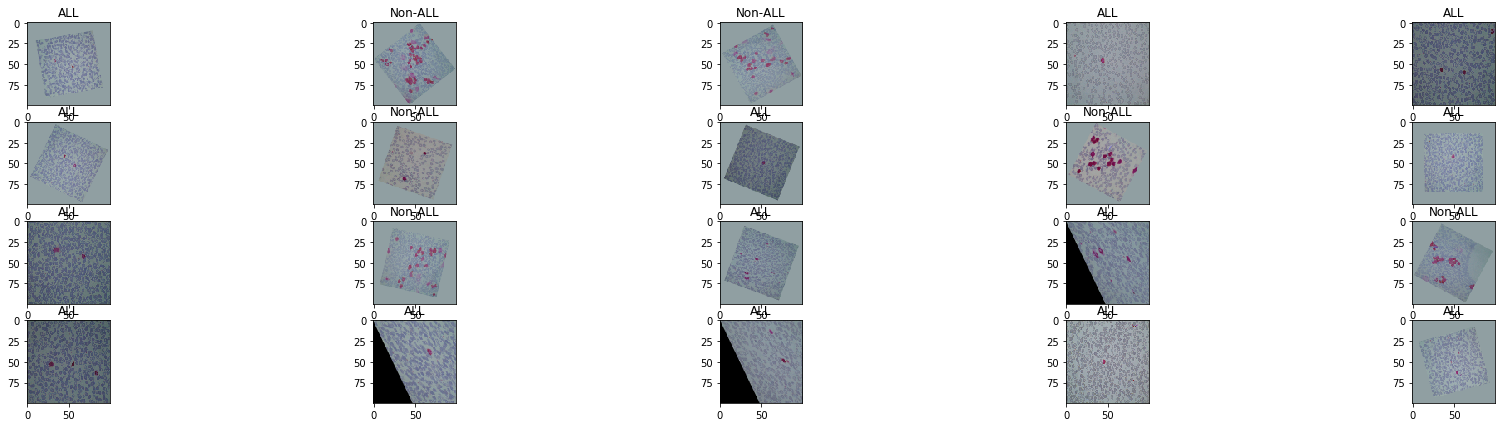

<Figure size 432x288 with 0 Axes>

In [19]:
y = np.argmax(labels, axis=-1)
fig, ax = plt.subplots(4,5, figsize=(30,7))
for i in range(0,20):
    ax[i//5, i%5].imshow(data[i])
    if y[i]==1:
        ax[i//5, i%5].set_title("Non-ALL")
    else:
        ax[i//5, i%5].set_title("ALL")
plt.show()
plt.clf()

# Network
## Build Network  

In [20]:
def build_network():
    """ Builds the network. """

    tf_model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1:])),
        tf.keras.layers.AveragePooling2D(
            pool_size=(2, 2), strides=None, padding='valid'),
        tf.keras.layers.Conv2D(30, (5, 5), strides=1,
            padding="valid", activation='relu'),
        tf.keras.layers.DepthwiseConv2D(30, (1, 1),
            padding="valid", activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2),
        tf.keras.layers.Activation('softmax', name='softmax')
    ],
    "AllJetsonNano")
    tf_model.summary()
    
    return tf_model
    
tf_model = build_network()

Model: "AllJetsonNano"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d (AveragePo (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 30)        2280      
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 17, 17, 30)        27030     
_________________________________________________________________
flatten (Flatten)            (None, 8670)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 17342     
_________________________________________________________________
softmax (Activation)         (None, 2)                 0         
Total params: 46,652
Trainable params: 46,652
Non-trainable params: 0
_________________________________________________

# Model
## Train Model 

In [21]:
def train(X_train, y_train, X_test, y_test):
    """ Trains the model. """
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=3, 
                                                verbose=0, 
                                                mode='auto', 
                                                restore_best_weights=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay = decay)

    tf_model.compile(optimizer=optimizer, loss='binary_crossentropy',
                    metrics=[tf.keras.metrics.BinaryAccuracy(name='acc'),
                            tf.keras.metrics.Precision(name='precision'),
                            tf.keras.metrics.Recall(name='recall'),
                            tf.keras.metrics.AUC(name='auc') ])

    history = tf_model.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            validation_steps=val_steps,
                            epochs=epochs, callbacks=[callback])
    return tf_model, history

tf_model, history = train(X_train, y_train, X_test, y_test)

Epoch 1/150
37/37 [==============================] - 12s 328ms/step - loss: 0.6876 - acc: 0.5805 - precision: 0.5805 - recall: 0.5805 - auc: 0.5681 - val_loss: 0.6801 - val_acc: 0.5520 - val_precision: 0.5520 - val_recall: 0.5520 - val_auc: 0.6858
Epoch 2/150
37/37 [==============================] - 11s 303ms/step - loss: 0.6554 - acc: 0.6339 - precision: 0.6339 - recall: 0.6339 - auc: 0.6838 - val_loss: 0.6389 - val_acc: 0.7871 - val_precision: 0.7871 - val_recall: 0.7871 - val_auc: 0.8182
Epoch 3/150
37/37 [==============================] - 12s 316ms/step - loss: 0.5953 - acc: 0.7415 - precision: 0.7415 - recall: 0.7415 - auc: 0.7845 - val_loss: 0.5801 - val_acc: 0.7921 - val_precision: 0.7921 - val_recall: 0.7921 - val_auc: 0.8459
Epoch 4/150
37/37 [==============================] - 11s 297ms/step - loss: 0.5442 - acc: 0.7763 - precision: 0.7763 - recall: 0.7763 - auc: 0.8200 - val_loss: 0.5215 - val_acc: 0.7550 - val_precision: 0.7550 - val_recall: 0.7550 - val_auc: 0.8338
Epoch 5/

Epoch 34/150
37/37 [==============================] - 11s 309ms/step - loss: 0.1555 - acc: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9881 - val_loss: 0.1636 - val_acc: 0.9356 - val_precision: 0.9356 - val_recall: 0.9356 - val_auc: 0.9866
Epoch 35/150
37/37 [==============================] - 12s 319ms/step - loss: 0.1398 - acc: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9901 - val_loss: 0.1790 - val_acc: 0.9282 - val_precision: 0.9282 - val_recall: 0.9282 - val_auc: 0.9810
Epoch 36/150
37/37 [==============================] - 12s 313ms/step - loss: 0.1504 - acc: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9880 - val_loss: 0.1608 - val_acc: 0.9406 - val_precision: 0.9406 - val_recall: 0.9406 - val_auc: 0.9862
Epoch 37/150
37/37 [==============================] - 12s 314ms/step - loss: 0.1576 - acc: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9865 - val_loss: 0.1669 - val_acc: 0.9406 - val_precision: 0.9406 - val_recall: 0.9406 - val_auc: 0.9854
Epoc

## Save Model 

In [22]:
def save_model_as_json(tf_model):
    """ Saves the model as JSON & SavedModel format"""

    with open(model_path, "w") as file:
        file.write(tf_model.to_json())
        
    tf_model.save(saved_model_dir)

save_model_as_json(tf_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../model/saved/assets


## Save Weights

In [23]:
def save_weights(tf_model):
    """ Saves the model weights """

    tf_model.save_weights(weights_path)
    print("Weights saved " + weights_path)
    
save_weights(tf_model)

Weights saved ../model/all_jetson_nano.h5


## Evaluate Model  

In [24]:
def evaluate(tf_model, X_test, y_test):
    """ Evaluates the model """

    metrics = tf_model.evaluate(
        X_test, y_test, verbose=0)
    for name, value in zip(tf_model.metrics_names, metrics):
        print("Metrics: " + name + " " + str(value))
        
evaluate(tf_model, X_test, y_test)

Metrics: loss 0.1324760615825653
Metrics: acc 0.9381188154220581
Metrics: precision 0.9381188154220581
Metrics: recall 0.9381188154220581
Metrics: auc 0.9902154207229614


### Predictions

In [25]:
def predictions(tf_model, X_train, X_test):
    """ Gets predictions. """

    train_preds = tf_model.predict(X_train)
    test_preds = tf_model.predict(X_test)
    
    return train_preds, test_preds
    
train_preds, test_preds = predictions(tf_model, X_train, X_test)

## Model Metrics 

### Accuracy

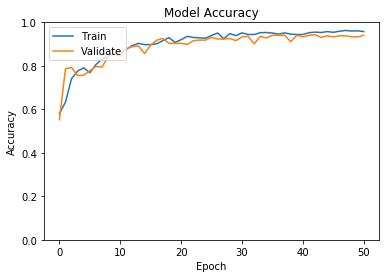

<Figure size 432x288 with 0 Axes>

In [26]:
def plot_accuracy(history):
    """ Plots the accuracy. """

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim((0, 1))
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.savefig('../model/plots/accuracy.png')
    plt.show()
    plt.clf()
    
plot_accuracy(history)

### Loss

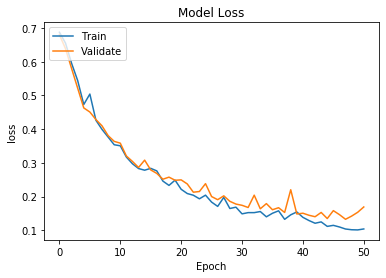

<Figure size 432x288 with 0 Axes>

In [27]:
def plot_loss(history):
    """ Plots the loss. """

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.savefig('../model/plots/loss.png')
    plt.show()
    plt.clf()
    
plot_loss(history)

### Precision

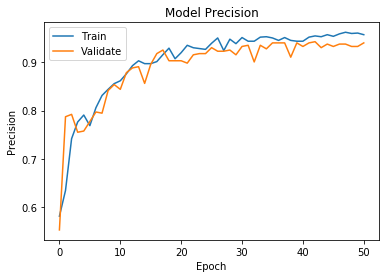

<Figure size 432x288 with 0 Axes>

In [28]:
def plot_precision(history):
    """ Plots the precision. """

    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.savefig('../model/plots/precision.png')
    plt.show()
    plt.clf()
    
plot_precision(history)

### AUC

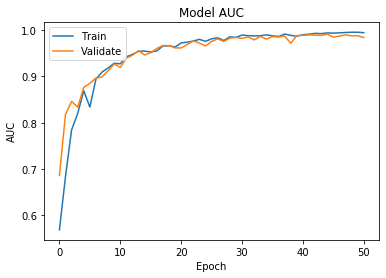

<Figure size 432x288 with 0 Axes>

In [29]:
def plot_auc(history):
    """ Plots the AUC. """

    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.savefig('../model/plots/auc.png')
    plt.show()
    plt.clf()
    
plot_auc(history)

### Recall

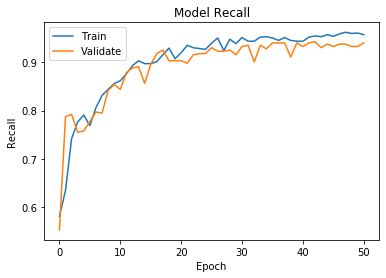

<Figure size 432x288 with 0 Axes>

In [30]:
def plot_recall(history):
    """ Plots the recall. """

    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.savefig('../model/plots/recall.png')
    plt.show()
    plt.clf()
    
plot_recall(history)

## Confusion Matrix

Confusion Matrix: [[220   0]
 [ 25 159]]



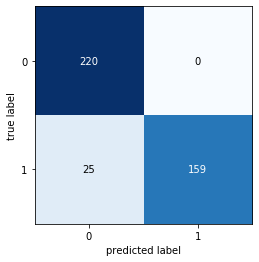

<Figure size 432x288 with 0 Axes>

In [31]:
def confusion_matrix_plot(y_test, test_preds):
    """ Plots the confusion matrix. """
    
    matrix = confusion_matrix(y_test.argmax(axis=1),
                              test_preds.argmax(axis=1))

    print("Confusion Matrix: " + str(matrix))
    print("")

    plot_confusion_matrix(conf_mat=matrix)
    plt.savefig('../model/plots/confusion-matrix.png')
    plt.show()
    plt.clf()
    
    return matrix
    
matrix = confusion_matrix_plot(y_test, test_preds)

## Figures Of Merit

In [32]:
def figures_of_merit(X_test, matrix):
    """ Calculates/prints the figures of merit.

    https://homes.di.unimi.it/scotti/all/
    """

    test_len = len(X_test)

    TP = matrix[1][1]
    TN = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]

    TPP = (TP * 100)/test_len
    FPP = (FP * 100)/test_len
    FNP = (FN * 100)/test_len
    TNP = (TN * 100)/test_len

    specificity = TN/(TN+FP)

    misc = FP + FN
    miscp = (misc * 100)/test_len

    print("True Positives: " + str(TP) + "(" + str(TPP) + "%)")
    print("False Positives: " + str(FP) + "(" + str(FPP) + "%)")
    print("True Negatives: " + str(TN) + "(" + str(TNP) + "%)")
    print("False Negatives: " + str(FN) + "(" + str(FNP) + "%)")

    print("Specificity: " + str(specificity))
    print("Misclassification: " + str(misc) + "(" + str(miscp) + "%)")

figures_of_merit(X_test, matrix)

True Positives: 159(39.35643564356435%)
False Positives: 0(0.0%)
True Negatives: 220(54.45544554455446%)
False Negatives: 25(6.188118811881188%)
Specificity: 1.0
Misclassification: 25(6.188118811881188%)


# Test Tensorflow Model

In [33]:
def load():
    """ Loads the model """

    with open(model_path) as file:
        m_json = file.read()

    model = tf.keras.models.model_from_json(m_json)
    model.load_weights(weights_path)

    model.summary()
    
    return model

model = load()

Model: "AllJetsonNano"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d (AveragePo (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 30)        2280      
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 17, 17, 30)        27030     
_________________________________________________________________
flatten (Flatten)            (None, 8670)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 17342     
_________________________________________________________________
softmax (Activation)         (None, 2)                 0         
Total params: 46,652
Trainable params: 46,652
Non-trainable params: 0
_________________________________________________

In [34]:
def reshape(img):
    """ Reshapes an image. """

    dx, dy, dz = img.shape
    input_data = img.reshape((-1, dx, dy, dz))
    input_data = input_data / 255.0

    return input_data

In [35]:
def predict(model, img):
    """ Gets a prediction for an image. """

    preds = model.predict(img)
    pred = np.argmax(preds, axis=-1)

    return pred

In [36]:
def test(model):
    """ Test mode

    Loops through the test directory and classifies the images.
    """

    files = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    totaltime = 0

    for testFile in os.listdir(testDataDir):
        if os.path.splitext(testFile)[1] in valid_files:
            files += 1
            fileName = testDataDir + testFile

            img = cv2.imread(fileName).astype(np.float32)
            print("Loaded test image " + fileName)
            img = cv2.resize(img, (dim, dim))
            print("Resized test image " + fileName)
            img = reshape(img)
            print("Reshaped test image " + fileName)

            start = time.time()
            prediction = predict(model, img)
            end = time.time()
            benchmark = end - start
            totaltime += benchmark

            msg = ""
            if prediction == 1 and "_1." in testFile:
                tp += 1
                msg = "Acute Lymphoblastic Leukemia correctly detected (True Positive) in " + str(benchmark) + " seconds."
            elif prediction == 1 and "_0." in testFile:
                fp += 1
                msg = "Acute Lymphoblastic Leukemia incorrectly detected (False Positive) in " + str(benchmark) + " seconds."
            elif prediction == 0 and "_0." in testFile:
                tn += 1
                msg = "Acute Lymphoblastic Leukemia correctly not detected (True Negative) in " + str(benchmark) + " seconds."
            elif prediction == 0 and "_1." in testFile:
                fn += 1
                msg = "Acute Lymphoblastic Leukemia incorrectly not detected (False Negative) in " + str(benchmark) + " seconds."
            print(msg)

    print("Images Classified: " + str(files))
    print("True Positives: " + str(tp))
    print("False Positives: " + str(fp))
    print("True Negatives: " + str(tn))
    print("False Negatives: " + str(fn))
    print("Total Time Taken: " + str(totaltime))
    
test(model)

Loaded test image ../model/data/test/Im041_0.jpg
Resized test image ../model/data/test/Im041_0.jpg
Reshaped test image ../model/data/test/Im041_0.jpg
Acute Lymphoblastic Leukemia correctly not detected (True Negative) in 0.1119682788848877 seconds.
Loaded test image ../model/data/test/Im053_1.jpg
Resized test image ../model/data/test/Im053_1.jpg
Reshaped test image ../model/data/test/Im053_1.jpg
Acute Lymphoblastic Leukemia correctly detected (True Positive) in 0.05084347724914551 seconds.
Loaded test image ../model/data/test/Im047_0.jpg
Resized test image ../model/data/test/Im047_0.jpg
Reshaped test image ../model/data/test/Im047_0.jpg
Acute Lymphoblastic Leukemia correctly not detected (True Negative) in 0.049056053161621094 seconds.
Loaded test image ../model/data/test/Im026_1.jpg
Resized test image ../model/data/test/Im026_1.jpg
Reshaped test image ../model/data/test/Im026_1.jpg
Acute Lymphoblastic Leukemia correctly detected (True Positive) in 0.08868265151977539 seconds.
Loaded t

## Convert To TFRT

In [42]:
def convert_to_tfrt():
    """ Converts the model to TFRT format """
    
    converter = trt.TrtGraphConverterV2(input_saved_model_dir=saved_model_dir)
    converter.convert()
    converter.save(tfrt_model_dir)
    
convert_to_tfrt()

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: ../model/tfrt/assets


## Test TFRT Model

In [38]:
def load_tfrt():
    """ Loads the tfrt model """

    tfrt_model = tf.saved_model.load(saved_model_dir)
    
    return tfrt_model

model_tfrt = load_tfrt()

In [39]:
def predict_tfrt(model, img):
    """ Gets a prediction for an image. """

    inference = model.signatures["serving_default"]
    prediction = inference(tf.constant(img,dtype=float))['softmax']
    prediction = data_labels[int(tf.argmax(prediction, axis=1))]
    
    return prediction

In [40]:
def test_tfrt(model):
    """ Test mode

    Loops through the test directory and classifies the images.
    """

    files = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    totaltime = 0

    for testFile in os.listdir(testDataDir):
        if os.path.splitext(testFile)[1] in valid_files:
            files += 1
            fileName = testDataDir + testFile

            img = cv2.imread(fileName).astype(np.float32)
            print("Loaded test image " + fileName)
            img = cv2.resize(img, (dim, dim))
            print("Resized test image " + fileName)
            img = reshape(img)
            print("Reshaped test image " + fileName)

            start = time.time()
            prediction = predict_tfrt(model, img)
            end = time.time()
            benchmark = end - start
            totaltime += benchmark

            msg = ""
            if prediction == 1 and "_1." in testFile:
                tp += 1
                msg = "Acute Lymphoblastic Leukemia correctly detected (True Positive) in " + str(benchmark) + " seconds."
            elif prediction == 1 and "_0." in testFile:
                fp += 1
                msg = "Acute Lymphoblastic Leukemia incorrectly detected (False Positive) in " + str(benchmark) + " seconds."
            elif prediction == 0 and "_0." in testFile:
                tn += 1
                msg = "Acute Lymphoblastic Leukemia correctly not detected (True Negative) in " + str(benchmark) + " seconds."
            elif prediction == 0 and "_1." in testFile:
                fn += 1
                msg = "Acute Lymphoblastic Leukemia incorrectly not detected (False Negative) in " + str(benchmark) + " seconds."
            print(msg)

    print("Images Classified: " + str(files))
    print("True Positives: " + str(tp))
    print("False Positives: " + str(fp))
    print("True Negatives: " + str(tn))
    print("False Negatives: " + str(fn))
    print("Total Time Taken: " + str(totaltime))
    
test_tfrt(model_tfrt)

Loaded test image ../model/data/test/Im041_0.jpg
Resized test image ../model/data/test/Im041_0.jpg
Reshaped test image ../model/data/test/Im041_0.jpg
Acute Lymphoblastic Leukemia correctly not detected (True Negative) in 0.0625162124633789 seconds.
Loaded test image ../model/data/test/Im053_1.jpg
Resized test image ../model/data/test/Im053_1.jpg
Reshaped test image ../model/data/test/Im053_1.jpg
Acute Lymphoblastic Leukemia correctly detected (True Positive) in 0.04581952095031738 seconds.
Loaded test image ../model/data/test/Im047_0.jpg
Resized test image ../model/data/test/Im047_0.jpg
Reshaped test image ../model/data/test/Im047_0.jpg
Acute Lymphoblastic Leukemia correctly not detected (True Negative) in 0.023001670837402344 seconds.
Loaded test image ../model/data/test/Im026_1.jpg
Resized test image ../model/data/test/Im026_1.jpg
Reshaped test image ../model/data/test/Im026_1.jpg
Acute Lymphoblastic Leukemia correctly detected (True Positive) in 0.028900623321533203 seconds.
Loaded 

# Convert to ONNX

In [43]:
def convert_to_onnx():
    """ Converts the model to ONNX format """
    
    !python3 -m tf2onnx.convert --saved-model ../model/saved --output ../model/all_jetson_nano.onnx --tag serve --signature_def serving_default
    
convert_to_onnx()

/home/hias/.conda/envs/all-jetson-nano/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-08-19 15:48:43,123 - INFO - Signatures found in model: [serving_default].
2021-08-19 15:48:43,123 - INFO - Output names: ['softmax']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2021-08-19 15:48:43,164 - WARNING - From /home/hias/.conda/envs/all-jetson-nano/lib/python3.7/site-packages/tf2onnx/tf_loader.py:557: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2021-08-19 15:48:43,176 - INFO - Using tensorflow=2.2.0, onnx=1.6.0, tf2onnx=1.8.4/None
2021-08-19 15:48:43,177 - INFO - Using opset <onnx, 9>
2021-08-19 15:48:43,182 - INFO - Compu

# Conclusion  

Here we trained a deep learning model for Acute Lymphoblastic Leukemia detection utilizing Intel® Optimization for Tensorflow* from the Intel® oneAPI AI Analytics Toolkit to optimize and accelarate training. We introduced a 6 layer deep learning model and applied data augmentation to increase the training data. 

We trained our model with a target of 150 epochs and used early stopping to avoid overfitting. The model trained for 37 epochs resulting in a fairly good fit, accuracy/precision/recall and AUC are satisfying. In addition the model reacts well during testing classifying each of the twenty unseen test images correctly. 

We see that the TFRT model performs considerably better than the Tensorflow model, improving classification time by 0.35 seconds.

- To test with the Python scripts continue to the [Python usage documentation](https://github.com/AMLResearchProject/ALL-Jetson-Nano/blob/main/docs/usage/python.md)
- To begin installation on your Jetson Nano continue to the  [Jetson Nano installation documentation](https://github.com/AMLResearchProject/ALL-Jetson-Nano/blob/main/docs/installation/jetson.md)

# Contributing
Asociación de Investigacion en Inteligencia Artificial Para la Leucemia Peter Moss encourages and welcomes code contributions, bug fixes and enhancements from the Github community.

Please read the [CONTRIBUTING](https://github.com/AMLResearchProject/Contributing-Guide/blob/main/CONTRIBUTING.md "CONTRIBUTING") document for a full guide to forking our repositories and submitting your pull requests. You will also find our code of conduct in the [Code of Conduct](https://github.com/AMLResearchProject/Contributing-Guide/blob/main/CODE-OF-CONDUCT.md) document.

## Contributors
- [Adam Milton-Barker](https://www.leukemiaairesearch.com/association/volunteers/adam-milton-barker "Adam Milton-Barker") - [Asociación de Investigacion en Inteligencia Artificial Para la Leucemia Peter Moss](https://www.leukemiaresearchassociation.ai "Asociación de Investigacion en Inteligencia Artificial Para la Leucemia Peter Moss") President/Founder & Lead Developer, Sabadell, Spain

&nbsp;

# Versioning
We use [SemVer](https://semver.org/) for versioning.

&nbsp;

# License
This project is licensed under the **MIT License** - see the [LICENSE](https://github.com/AMLResearchProject/ALL-Arduino-Nano-33-BLE-Sense-Classifier/blob/main/LICENSE "LICENSE") file for details.

&nbsp;

# Bugs/Issues
We use the [repo issues](https://github.com/AMLResearchProject/ALL-Jetson-Nano/issues "repo issues") to track bugs and general requests related to using this project. See [CONTRIBUTING](https://github.com/AMLResearchProject/Contributing-Guide/blob/main/CONTRIBUTING.md "CONTRIBUTING") for more info on how to submit bugs, feature requests and proposals.